# About Dataset
- Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

- Number of reviews: 568,454
- Number of users: 256,059
- Number of products: 74,258
- Timespan: Oct 1999 - Oct 2012
- Number of Attributes/Columns in data: 10
- Attribute Information:
- Id
- ProductId - unique identifier for the product
- UserId - unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the * review helpful or not
- Score - rating between 1 and 5
- Time - timestamp for the review
- Summary - brief summary of the review
- Text - text of the review

# Task:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

# Approach-
Q. How to determine if a review is positive or negative?

A. We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Ref:
    
- https://github.com/arunm8489/Amazon_Fine_Food_Reviews-sentiment_analysis/blob/master/Notebooks/1.%20EDA_and_datapreprocessing.ipynb

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

# Reading Data

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

In [3]:
data = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [4]:
print(f'Shape of data is {data.shape}')

data.head()

Shape of data is (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# data = pd.read_csv(r"C:\Users\akshat.agrawal\Desktop\ML models\Amazon Fine Food Reviews Sentimental Analysis\Reviews.csv")

# Exploratory data Analysis

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# no null values

In [7]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

# Duplicate entries

In [8]:
data.duplicated().sum()

0

In [9]:
data[data.duplicated(subset=['UserId','ProfileName','Time','Text'])]

# same user at the same timn writing same or different text - can be spams or duplicates, which needs to be dropped

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
...,...,...,...,...,...,...,...,...,...,...
568409,568410,B0018CLWM4,A2PE0AGWV6OPL7,Dark Water Mermaid,3,3,5,1309651200,Quality & affordable food,I was very pleased with the ingredient quality...
568410,568411,B0018CLWM4,A88HLWDCU57WG,R28,2,2,5,1332979200,litter box,My main reason for the five star review has to...
568411,568412,B0018CLWM4,AUX1HSY8FX55S,DAW,1,1,5,1319500800,Happy Camper,I bought this to try on two registered Maine C...
568412,568413,B0018CLWM4,AVZ2OZ479Q9E8,Ai Ling Chow,0,0,5,1336435200,Two Siberians like it!,When we brought home two 3-month-old purebred ...


In [10]:
# example - check for this user AQM74O8Z4FMS0

data[data['UserId']=='AQM74O8Z4FMS0']

# we see that the same user at the same time has written 3 reviews - exactly same - duplicates 
# so we need to drop these duplicate records

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2295,2296,B0001VWE02,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
70752,70753,B004EKQM4U,AQM74O8Z4FMS0,Sunshine,9,10,5,1335830400,Excellent Product at incredible price,Taste: These nibs taste a bit bitter just as t...


In [11]:
# dropping duplicate entries

dup = data[data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
dup.shape

(232415, 10)

In [12]:
# example for duplicate entry
# 'AR5J8UI46CURR'
dup[dup['UserId'] == 'A395BORC6FGVXV']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
136303,136304,B002Y7526Y,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
544172,544173,B000U9WZ54,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [13]:
# Now we will keep only the first entry and will delete rest of the entry

df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(393933, 10)

In [14]:
remaining_data = ((df.shape[0])/(data.shape[0]))*100
print("Remaining Data : ",round(remaining_data,2), "%")

Remaining Data :  69.3 %


# Analyisis of Reviews over time

In [15]:
# time column from UNIX to datetime

df['Time'] = pd.to_datetime(df['Time'], unit = 's')

In [16]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [17]:
dff = df[['Time','Text','Score']]
dff.Time = df.Time.dt.strftime('%Y-%m')
dff.Time

0         2011-04
1         2012-09
2         2008-08
3         2011-06
4         2012-10
           ...   
568449    2011-03
568450    2012-03
568451    2012-02
568452    2012-03
568453    2012-05
Name: Time, Length: 393933, dtype: object

In [18]:
dff['Year'] = df.Time.dt.strftime('%Y')
dff['Year']

0         2011
1         2012
2         2008
3         2011
4         2012
          ... 
568449    2011
568450    2012
568451    2012
568452    2012
568453    2012
Name: Year, Length: 393933, dtype: object

In [19]:
dff = dff.sort_values(by=['Time']).reset_index(drop=True)

In [20]:
dff.head()

,Time,Text,Score,Year
0,1999-10,I can remember seeing the show when it aired o...,5,1999
1,1999-10,this witty little book makes my son laugh at l...,5,1999
2,1999-12,"A twist of rumplestiskin captured on film, sta...",5,1999
3,1999-12,Beetlejuice is a well written movie ..... ever...,5,1999
4,2000-01,I bought a few of these after my apartment was...,5,2000


In [21]:
dff.tail()

,Time,Text,Score,Year
393928,2012-10,"Remember when you were a kid, on those hot, ho...",5,2012
393929,2012-10,I at my first pop corner chip today . . . I fi...,5,2012
393930,2012-10,My puggle can devour most bones in minutes. Th...,5,2012
393931,2012-10,I used these to make vegan peanut butter cups ...,4,2012
393932,2012-10,Not worth the money. Gluey and no pumpkin tast...,1,2012


# we see the records are from 10-1999 to 10-2012

In [22]:
reviews_over_time = dff.groupby('Year')['Score'].count().reset_index()

In [23]:
reviews_over_time

,Year,Score
0,1999,4
1,2000,17
2,2001,8
3,2002,33
4,2003,99
5,2004,445
6,2005,1069
7,2006,4749
8,2007,15795
9,2008,23134


<AxesSubplot:title={'center':'Count of Reviews over time'}, xlabel='Year', ylabel='Score'>

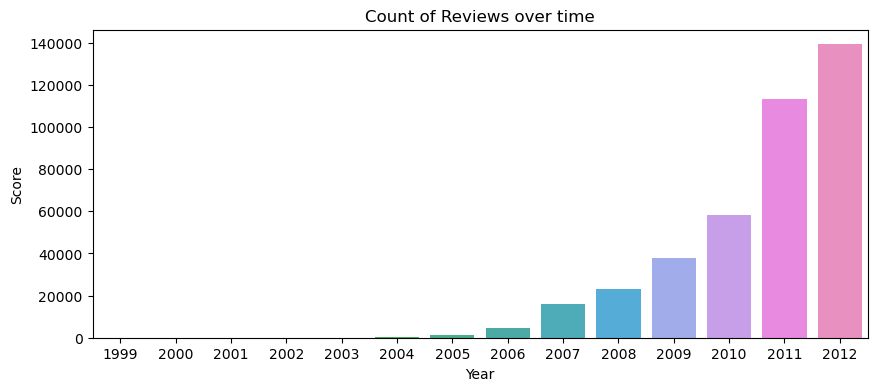

In [24]:
plt.figure(figsize=(10,4))
plt.xlabel("Year")
plt.ylabel("Count of Reviews")
plt.title("Count of Reviews over time")
sns.barplot(x=reviews_over_time['Year'], y=reviews_over_time['Score'])

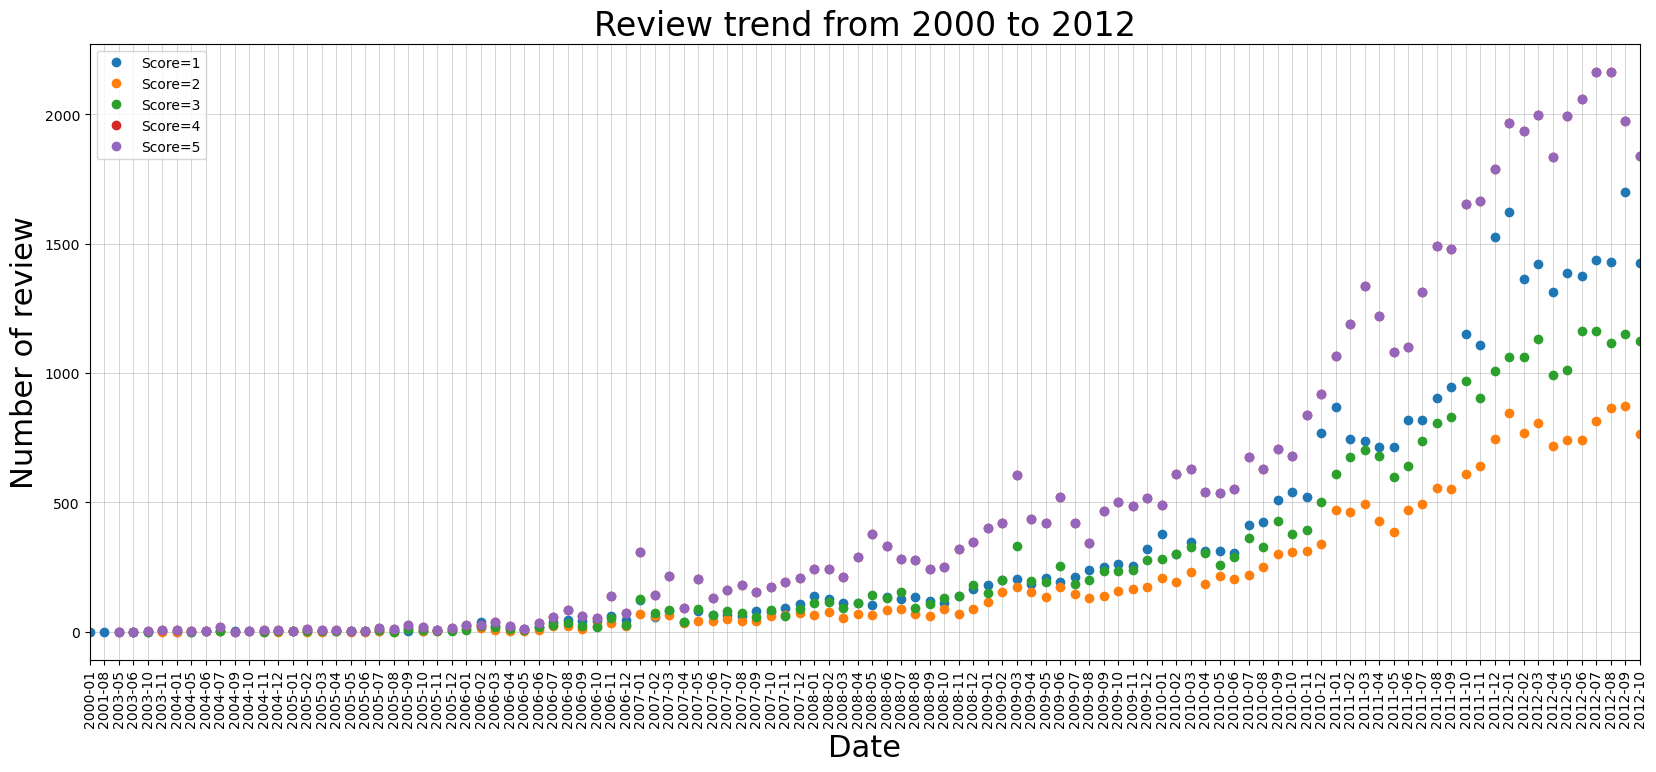

In [25]:
# Reviews over time acc to Year and month with Individual score counts

dff = dff.sort_values(by=['Time']).reset_index(drop=True)
dff_1 = dff[dff['Score'] == 1]
dff_2 = dff[dff['Score'] == 2]
dff_3 = dff[dff['Score'] == 3]
dff_4 = dff[dff['Score'] == 4]
dff_5 = dff[dff['Score'] == 5]

dff_1 = dff_1.groupby('Time')['Score'].count().reset_index()
dff_2 = dff_2.groupby('Time')['Score'].count().reset_index()
dff_3 = dff_3.groupby('Time')['Score'].count().reset_index()
dff_5 = dff_4.groupby('Time')['Score'].count().reset_index()
dff_4 = dff_4.groupby('Time')['Score'].count().reset_index()

plt.figure(figsize=(20,8))

plt.plot_date(x=dff_1['Time'],y=dff_1['Score'],label='Score=1')
plt.plot_date(x=dff_2['Time'],y=dff_2['Score'],label='Score=2')
plt.plot_date(x=dff_3['Time'],y=dff_3['Score'],label='Score=3')
plt.plot_date(x=dff_4['Time'],y=dff_4['Score'],label='Score=4')
plt.plot_date(x=dff_5['Time'],y=dff_5['Score'],label='Score=5')
plt.grid(linewidth=0.5,alpha=0.75)
plt.xticks(rotation=90)
plt.xlim('2000-01','2012-10')
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Review trend from 2000 to 2012',fontsize=24);
plt.savefig('review_trend.png')
plt.legend()
plt.show()

# Analysis on Score (Target Variable)

- Now we will create our target variable from review stars. Before that we will filter only those reviews with rating > 3(positive) and less than 3(negative)


In [26]:
df[df['Score']==3]
# there are around 29000 rows which have score as 3

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
45,46,B001EO5QW8,A39Z97950MCTQE,K. A. Freel,0,0,3,2008-03-11,Hearty Oatmeal,This seems a little more wholesome than some o...
47,48,B001EO5QW8,A26AY1TFK8BQXQ,"kbogo ""shoelover""",1,2,3,2008-01-12,Mushy,"The flavors are good. However, I do not see a..."
49,50,B001EO5QW8,A276999Y6VRSCQ,JMay,0,1,3,2012-04-10,Same stuff,This is the same stuff you can buy at the big ...
53,54,B000G6RPMY,AQ9DWWYP2KJCQ,"Roel Trevino ""protomex""",0,0,3,2010-07-02,not ass kickin,we're used to spicy foods down here in south t...
60,61,B004N5KULM,A1ZR8O62VSU4OK,"Lisa J. Szlosek ""lisa""",2,4,3,2011-10-16,Better price for this at Target,Watch your prices with this. While the assort...
...,...,...,...,...,...,...,...,...,...,...
568336,568337,B001BOAOLY,A3CMHE6IJV79QM,Nancy J. Lumpkins,0,0,3,2010-09-26,Not Enough Lemon!,These taste basically as if there is no lemon ...
568355,568356,B002XO3Q52,A7DMNT5YZ3JV1,RJT,0,0,3,2012-04-16,Paid too much,I paid well over labeled price and the produc...
568369,568370,B000LKVRQA,A2ZX818P92CM7F,"Gregg Somers ""chillerdad""",1,2,3,2010-08-25,This is Earl Grey!???,"An admitted fan of Stash Earl Grey, neverthele..."
568379,568380,B000H28ABW,A1XVKAMXSOW8ZV,"C. E. Hunsicker ""Hatshepsut""",2,3,3,2009-10-26,Just OK,I hadn't tried this taco seasoning prior to pu...


In [27]:
df['Score'].value_counts()

5    250962
4     56094
1     36306
3     29769
2     20802
Name: Score, dtype: int64

In [28]:
print("Before : ",df.shape)

df = df[df['Score'] != 3]  #removing the rows which have score =3
print("After : ",df.shape )


#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')


df['Score'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
df.head(3)

Before :  (393933, 10)
After :  (364164, 10)
Remaining data is 64.06217565537405


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...


In [29]:
df['Score'].value_counts()

1    307056
0     57108
Name: Score, dtype: int64

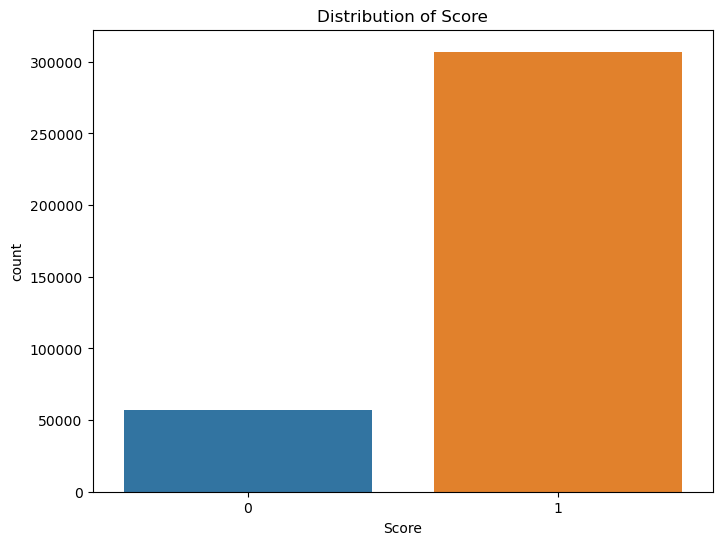

In [30]:
plt.figure(figsize=(8,6))
sns.countplot(df['Score'])
plt.title('Distribution of Score')
plt.show()

# Observation: 
- It is clear that we have an imbalenced dataset for classification. So We cannot choose accuracy as a metric. So here we will go with AUC(Area under ROC curve)

- Why accuracy not for imbalanced datasets?

Consider a scenario like this where we have imbalenced dataset. For example consider case of credit card fraud detection with 98% percentage of points as non-fraud(1) and rest 2% points as fraud(1). In such cases even if we predict all the points as non-fraud also we will get 98% accuracy. But actually it is not the case. So we can't use accuracy as a metric.

- What is AUC ROC?

AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

# Analysis On ProductId and UserId


In [31]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...


In [32]:
df['UserId'].nunique()

243412

In [33]:
shopping = df.groupby('UserId')['ProductId'].count().reset_index()
shopping.columns = ['UserId','No of Products Purchased']

In [34]:
shopping

,UserId,No of Products Purchased
0,#oc-R103C0QSV1DF5E,1
1,#oc-R109MU5OBBZ59U,1
2,#oc-R10LFEMQEW6QGZ,1
3,#oc-R10UA029WVWIUI,1
4,#oc-R115TNMSPFT9I7,1
...,...,...
243407,AZZV9PDNMCOZW,3
243408,AZZVNIMTTMJH6,1
243409,AZZY649VYAHQS,1
243410,AZZYCJOJLUDYR,1


In [35]:
shopping.describe()

,No of Products Purchased
count,243412.000000
mean,1.496081
std,2.537677
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,310.000000


- We can see that majority of the users purchased only 1 product. Maximum number of product purchased by a single user is 310



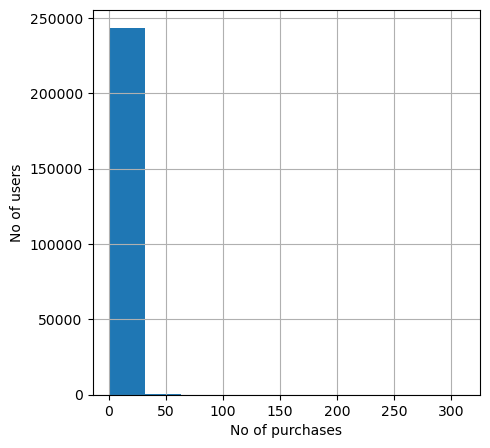

In [36]:
plt.figure(figsize=(5,5))
shopping['No of Products Purchased'].hist()
plt.xlabel('No of purchases')
plt.ylabel('No of users')
plt.show()

# Analysis on HelpfulnessNumerator and HelpfulnessDenominator
- Helpfulness Numerator: Number of users who found the review helpful
- Helpfulness Denominator: Number of users who indicated whether they found the review helpful or not

In [37]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,2008-06-08,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,2008-10-25,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [38]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df.shape

(364162, 10)

In [39]:
remaining_data = ((df.shape[0])/(data.shape[0]))*100
print("Remaining Data : ",round(remaining_data,2), "%")

Remaining Data :  64.06 %


In [40]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# Preprocessing

- Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

# Hence in the Preprocessing phase we do the following in the order below:-

- Begin by removing the html tags
- Remove any punctuations or limited set of special characters like , or . or # etc.
- Check if the word is made up of english letters and is not alpha-numeric
- Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
- Convert the word to lowercase
- Remove Stopwords
- Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)


- After which we collect the words used to describe positive and negative reviews

# Just for understanding

In [41]:
# printing some random reviews
sent_0 = df['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = df['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df['Text'].values[4900]
print(sent_4900)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [42]:
# remove urls from text in python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [43]:
# to find if your text has html tags ot not
# https://stackoverflow.com/questions/24856035/how-to-detect-with-python-if-the-string-contains-html-code

from bs4 import BeautifulSoup

html_sentence = """<html>
... <head><title>I'm title</title></head>
... </html>"""

non_html = "This is not an html"

print(bool(BeautifulSoup(html_sentence, "html.parser").find()))

print(bool(BeautifulSoup(non_html, "html.parser").find()))

True
False


In [44]:
def html_tags(text):
    return bool(BeautifulSoup(text, "html.parser").find())

In [45]:
html_tags("Akshat is the best Data Scientist")

False

In [46]:
html_tags("<h>Hey, How are you?</h")

True

In [47]:
df['Text'].apply(html_tags)

0         False
1         False
2         False
3         False
4         False
          ...  
568449    False
568450    False
568451    False
568452    False
568453    False
Name: Text, Length: 364162, dtype: bool

In [48]:
df['Text'].apply(html_tags).value_counts()

# there are around 93149 Texts in which we have HTML tags, which needs to be removed further

False    271013
True      93149
Name: Text, dtype: int64

# to remove all the tags from a text

- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

In [49]:
#Method 1:
from bs4 import BeautifulSoup

text = '''
<td><a href="http://www.irit.fr/SC">Signal et Communication</a>
<br/><a href="http://www.irit.fr/IRT">Ingénierie Réseaux et Télécommunications</a>
</td>
'''
soup = BeautifulSoup(text)

print(soup)
print("="*50)
print(soup.get_text())

<html><body><td><a href="http://www.irit.fr/SC">Signal et Communication</a>
<br/><a href="http://www.irit.fr/IRT">Ingénierie Réseaux et Télécommunications</a>
</td>
</body></html>
Signal et Communication
Ingénierie Réseaux et Télécommunications




In [50]:
str = "https://stackoverflow.com/a/5843547/4084039 <t>just some text to check if the tag is removed</t>"

print(str)
print(BeautifulSoup(str).get_text()) # we can see the tags are removed

https://stackoverflow.com/a/5843547/4084039 <t>just some text to check if the tag is removed</t>
https://stackoverflow.com/a/5843547/4084039 just some text to check if the tag is removed


In [51]:
#Method 2:
html_text = '''
<td><a href="http://www.irit.fr/SC">Signal et Communication</a>
<br/><a href="http://www.irit.fr/IRT">Ingénierie Réseaux et Télécommunications</a>
</td>
'''
soup = BeautifulSoup(html_text, 'lxml')
# lxml is a library for processing XML and HTML in the Python language.
text = soup.get_text()

print(soup)
print("="*50)
print(text)

<html><body><td><a href="http://www.irit.fr/SC">Signal et Communication</a>
<br/><a href="http://www.irit.fr/IRT">Ingénierie Réseaux et Télécommunications</a>
</td>
</body></html>
Signal et Communication
Ingénierie Réseaux et Télécommunications




In [52]:
# Fesw more examples

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

# Contraction

- How and why to deal with contractions

https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b

https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/

In [53]:
# !pip install contractions

In [54]:
# Method 1: using contractions library

import contractions
print(contractions.fix("you've"))
print(contractions.fix("he's"))

print(contractions.fix("We ain’t all the same")) 
# this sentence can have various possibilities:
#ain't -> am not
#ain't -> are not
#ain't -> is not
#ain't -> has not
#ain't -> have not

# for such problems we use pycontractions


you have
he is
We are not all the same


# Method 2: Using pycontractions

- https://pypi.org/project/pycontractions/

In [55]:
# Method 3:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


test = "Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it."
print(decontracted(test))

Hey I am Yann, how are you and how is it going ? That is interesting: I would love to hear more about it.


In [56]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.


#  Removing words which have numbers in them:

- https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370

In [57]:
# Method 1: string manipulation
words = "ABCD abcd AB55 55CD A55D 5555"
' '.join(s for s in words.split() if not any(c.isdigit() for c in s))

'ABCD abcd'

In [58]:
# Method 2: using Regex

words = "ABCD abcd AB55 55CD A55D 5555"
re.sub(r'\w*\d\w*', '', words).strip()

'ABCD abcd'

In [59]:
# Few more examples

sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


# Remove all special characters, punctuation and spaces from string

- https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547

In [60]:
# Method 1: using isalnum() function

string = "Special $#! characters   spaces 888323"

print(string.isalnum()) 

string = ''.join(e for e in string if e.isalnum())
print(string)

print(string.isalnum())

False
Specialcharactersspaces888323
True


In [61]:
# Method 2:

mystring="Special $#! characters   spaces 888323"
re.sub('[^A-Za-z0-9]+', '', mystring)


'Specialcharactersspaces888323'

In [62]:
# Method 3:

string="Special $#! characters   spaces 888323"
re.sub('\W+','', string)

# this is typically 3x faster than the next fastest provided top answer.

# Caution should be taken when using this option. Some special characters (e.g. ø) may not be striped using this method.

'Specialcharactersspaces888323'

In [63]:
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Aboulutely love Popchips I first tried these healthy chips at a marathon i did in California I like this variety pack because i got to try alot of the flavors ive never had 


# Stopwords Removal 
- https://gist.github.com/sebleier/554280

In [64]:
# we are creating our own stopwords list rather than using library - Reason below
# we are removing the words from the stop words list: ('no', 'nor', 'not') as if we remove these from the sentence then the meaning of whole sentence would completely change
# <br /><br /> ==> after the above steps(removing tags), we are getting "br br" multiple times
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# tqdm

- https://towardsdatascience.com/progress-bars-for-python-with-tqdm-4dba0d4cb4c

In [65]:
# Combining all the above steps 
from tqdm import tqdm
# tqdm is for printing the status bar
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(df['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)   # removing html tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # removing tags
    sentence = decontracted(sentence)    # removing contractions
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 364162/364162 [01:31<00:00, 3988.28it/s]


In [66]:
preprocessed_reviews

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted not sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven not chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces

In [67]:
#combining required columns
df['clean_text'] = preprocessed_reviews

In [68]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...


In [69]:
final_df = df[['Time','clean_text','Score']]
#reseting index
final_df = final_df.reset_index(drop=True)
final_df.head(2)

,Time,clean_text,Score
0,2011-04-27,bought several vitality canned dog food produc...,1
1,2012-09-07,product arrived labeled jumbo salted peanuts p...,0


In [70]:
#saving processed file
final_df.to_csv('processed_df.csv',index=False)

# Reading PreProcessed file

In [4]:
df = pd.read_csv('processed_df.csv')
print(df.shape)
df.head()

(364162, 3)


,Time,clean_text,Score
0,2011-04-27,bought several vitality canned dog food produc...,1
1,2012-09-07,product arrived labeled jumbo salted peanuts p...,0
2,2008-08-18,confection around centuries light pillowy citr...,1
3,2011-06-13,looking secret ingredient robitussin believe f...,0
4,2012-10-21,great taffy great price wide assortment yummy ...,1


In [5]:
df['clean_text'][0]

'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364162 entries, 0 to 364161
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        364162 non-null  object
 1   clean_text  363184 non-null  object
 2   Score       364162 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.3+ MB


In [7]:
df.isna().sum()

Time            0
clean_text    978
Score           0
dtype: int64

In [8]:
df = df.dropna(axis=0)
df.shape

(363184, 3)

In [9]:
# We are considering time beacuse our reviews are developed over time.So splitting based on that makes more sense

#sampling 100000 points 


df = df.sample(100000,random_state=100)


#sortimg based on time
# df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)
df.head(2)

,Time,clean_text,Score
0,1999-12-02,beetlejuice well written movie everything exce...,1
1,1999-12-06,twist rumplestiskin captured film starring mic...,1


In [14]:
sentences = df[df['Score'] == 1]['clean_text']

In [15]:
type(sentences)

pandas.core.series.Series

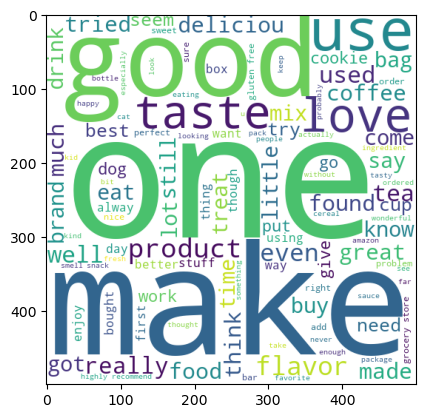

In [139]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size=10, background_color='white') 

positive_wc = wc.generate(df[df['Score'] == 1]['clean_text'].str.cat(sep = " "))

plt.imshow(positive_wc)

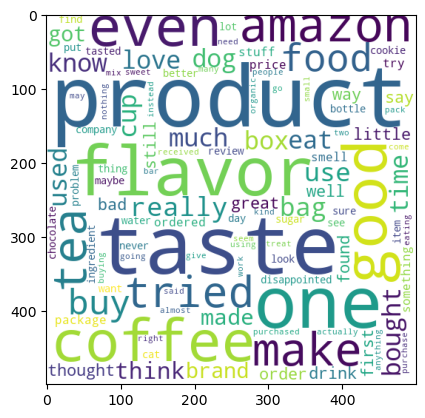

In [140]:
negative_wc = wc.generate(df[df['Score'] == 0]['clean_text'].str.cat(sep = " "))

plt.imshow(negative_wc)

In [77]:
df['Score'].value_counts()

# imbalanced data

1    84380
0    15620
Name: Score, dtype: int64

# Precision, Rcall and F1-score 
Ref Link: - https://towardsdatascience.com/the-f1-score-bec2bbc38aa6

# Stratified Sampling 

# stratify = y

- Stratified Train-Test Splits

Some classification problems do not have a balanced number of examples for each class label. As such, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

This is called a stratified train-test split.

We can achieve this by setting the “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.

In [78]:
#splitting data to train.cv and test

from sklearn.model_selection import train_test_split
x = df['clean_text']
y = df['Score']


X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

Before Vectorization
Train---> (70000,) (70000,)
Test----> (30000,) (30000,)


# Bag of Words

In [79]:
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print("After Vectorization(Bag of Words)")
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

After Vectorization(Bag of Words)
shape of X_train_bow is (70000, 51047)
shape of X_test_bow is (30000, 51047)


# Data Leakage
- There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
To avoid the issue of data-leakag, make sure to split your data first and then vectorize it.
While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.

In [80]:
len(bow.vocabulary_) # there are 51047 words in the vocabulary

51047

# just for showing how BOW works

# uni gram

In [81]:
test_df = pd.DataFrame({'text' : ['Akshat is a good Data scientist','Akshat is the best Data Scientist in the country'] 
                        , 'output' : [1,0] })

In [82]:
test_df

,text,output
0,Akshat is a good Data scientist,1
1,Akshat is the best Data Scientist in the country,0


In [83]:
cv = CountVectorizer() # BOW or Unigram

In [84]:
cv.fit(test_df['text'])

CountVectorizer()

In [85]:
cv.transform(test_df['text'])

<2x9 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [86]:
cv.vocabulary_

{'akshat': 0,
 'is': 6,
 'good': 4,
 'data': 3,
 'scientist': 7,
 'the': 8,
 'best': 1,
 'in': 5,
 'country': 2}

In [87]:
cv.transform(test_df['text']).toarray()

array([[1, 0, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 1, 2]], dtype=int64)

# Bi gram

In [88]:
cv2=CountVectorizer(ngram_range=(2,2))

In [89]:
cv2.fit_transform(test_df['text']).toarray()

array([[1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0, 1, 1, 1, 1]], dtype=int64)

In [90]:
cv2.vocabulary_

{'akshat is': 0,
 'is good': 5,
 'good data': 3,
 'data scientist': 2,
 'is the': 6,
 'the best': 8,
 'best data': 1,
 'scientist in': 7,
 'in the': 4,
 'the country': 9}

# How TF-IDF works - tells the importance of each element.

In [91]:
test_tfidf = TfidfVectorizer()
test_tfidf.fit_transform(test_df['text']).toarray()

array([[0.4090901 , 0.        , 0.        , 0.4090901 , 0.57496187,
        0.        , 0.4090901 , 0.4090901 , 0.        ],
       [0.23684101, 0.33287178, 0.33287178, 0.23684101, 0.        ,
        0.33287178, 0.23684101, 0.23684101, 0.66574355]])

In [92]:
test_tfidf.vocabulary_

{'akshat': 0,
 'is': 6,
 'good': 4,
 'data': 3,
 'scientist': 7,
 'the': 8,
 'best': 1,
 'in': 5,
 'country': 2}

In [93]:
test_tfidf1 = TfidfVectorizer(ngram_range=(1,2)) # combination of unigram and bi gram
test_tfidf1.fit_transform(test_df['text']).toarray()

array([[0.2895694 , 0.2895694 , 0.        , 0.        , 0.        ,
        0.2895694 , 0.2895694 , 0.40697968, 0.40697968, 0.        ,
        0.        , 0.2895694 , 0.40697968, 0.        , 0.2895694 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.17766918, 0.17766918, 0.24970783, 0.24970783, 0.24970783,
        0.17766918, 0.17766918, 0.        , 0.        , 0.24970783,
        0.24970783, 0.17766918, 0.        , 0.24970783, 0.17766918,
        0.24970783, 0.49941565, 0.24970783, 0.24970783]])

In [94]:
test_tfidf1.vocabulary_

{'akshat': 0,
 'is': 11,
 'good': 7,
 'data': 5,
 'scientist': 14,
 'akshat is': 1,
 'is good': 12,
 'good data': 8,
 'data scientist': 6,
 'the': 16,
 'best': 2,
 'in': 9,
 'country': 4,
 'is the': 13,
 'the best': 17,
 'best data': 3,
 'scientist in': 15,
 'in the': 10,
 'the country': 18}

# Penalty in Logistic Regression or basically Regularization technique

When we have multiple variables in our logistic regression model, it might be useful to find a reduced set of variables resulting to an optimal performing model.

Penalized logistic regression imposes a penalty to the logistic model for having too many variables. This results in shrinking the coefficients of the less contributive variables toward zero. This is also known as regularization.

# Logistic Regression on BOW 

In [95]:
# setting parameters - 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score

penalty = ['l1','l2']
C=[10**x for x in range(-4,4)]
grid={"penalty":penalty,"C":C}

# object of  Logistic Regression Model
logreg=LogisticRegression(solver='sag', class_weight='balanced')


model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)

# fitting the model with training data
model.fit(X_train_bow,y_train)

print(model.best_params_)

final_lr_model = LogisticRegression(**model.best_params_)
final_lr_model.fit(X_train_bow,y_train)

y_pred_lr = final_lr_model.predict(X_test_bow)

print(y_pred_lr)

print("Test Data Shape : ", y_test.shape)

print("Predicted Data shape : ", y_pred_lr.shape)

print("F1 score with Logistic Regression : ", f1_score(y_pred_lr, y_test))
print("Recall score with Logistic Regression : ", recall_score(y_pred_lr,y_test))

{'C': 1000, 'penalty': 'l2'}
[0 1 1 ... 0 1 1]
Test Data Shape :  (30000,)
Predicted Data shape :  (30000,)
F1 score with Logistic Regression :  0.9456832475700401
Recall score with Logistic Regression :  0.943952454048097


In [96]:
statement = bow.transform(["I hate the cloth"])

In [97]:
final_lr_model.predict(statement)

array([1], dtype=int64)

In [98]:
statement1 = bow.transform(["I do not love  the cloth"])

In [99]:
final_lr_model.predict(statement1)

array([1], dtype=int64)

# Logistic Regression on BOW with parameter class weight = balanced

# used class_weight = 'balanced' above , so we can skip this part of the notebook/

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#penalty = ['l1','l2']
#C=[10**x for x in range(-4,4)]
#grid={"penalty":penalty,"C":C}

# object of  Logistic Regression Model

#model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)

# fitting the model with training data



lr_bal = LogisticRegression(solver='sag', class_weight='balanced')
lr_bal.fit(X_train_bow,y_train)

LogisticRegression(class_weight='balanced', solver='sag')

In [101]:
y_pred_lr_bal = lr_bal.predict(X_test_bow)
y_pred_lr_bal

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [102]:
y_pred_lr_bal.shape

(30000,)

In [103]:
print("F1 score with Balanced Logistic Regression : ", f1_score(y_pred_lr_bal,y_test))
print("Recall score with Balanced Logistic Regression : ", recall_score(y_pred_lr_bal,y_test))

F1 score with Balanced Logistic Regression :  0.9377069282648681
Recall score with Balanced Logistic Regression :  0.9714176829268293


# Logistic Regression on TF-IDF

# BI-GRAM

X = df['clean_text']
y = df['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

# by default it is uni gram, we have used bi gram here
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
vectorizer.fit(X_train)

tfidf_features = vectorizer.get_feature_names()
print(len(tfidf_features))

# we use the fitted CountVectorizer to convert the text to vector

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("After Vectorization(TF-IDF)")
print("Length of Vocabulary : ", len(vectorizer.vocabulary_))
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.get_shape()))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.get_shape()))



penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}


lr_tfidf = LogisticRegression(solver='sag')
lr_tfidf_model = GridSearchCV(lr_tfidf, grid, cv=5, return_train_score=True)


lr_tfidf_model.fit(X_train_tfidf,y_train)

print("Model with best parameters :\n",lr_tfidf_model.best_params_)


lr_final_tfidf = LogisticRegression(**lr_tfidf_model.best_params_)
lr_final_tfidf.fit(X_train_tfidf, y_train)
print(lr_final_tfidf)


y_pred_tfidf_lr = lr_final_tfidf.predict(X_test_tfidf)
print(y_pred_tfidf_lr.shape)
print(y_pred_tfidf_lr)


print("F1 Score with Logistic Regression Bi-gram Tf-IDF : ", f1_score(y_pred_tfidf_lr, y_test))
print("Recall Score with Logistic Regression Bi-gram Tf-IDF : ", recall_score(y_pred_tfidf_lr, y_test))

In [104]:
# UNI-GRAM

X = df['clean_text']
y = df['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

# by default it is uni gram, we have used bi gram here
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
vectorizer.fit(X_train)

tfidf_features = vectorizer.get_feature_names()
print(len(tfidf_features))

# we use the fitted CountVectorizer to convert the text to vector

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("After Vectorization(TF-IDF)")
print("Length of Vocabulary : ", len(vectorizer.vocabulary_))
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.get_shape()))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.get_shape()))


penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}


lr_tfidf = LogisticRegression(solver='sag')
lr_tfidf_model = GridSearchCV(lr_tfidf, grid, cv=5, return_train_score=True)

lr_tfidf_model.fit(X_train_tfidf,y_train)

print("Model with best parameters :\n",lr_tfidf_model.best_params_)


lr_final_tfidf = LogisticRegression(**lr_tfidf_model.best_params_)
lr_final_tfidf.fit(X_train_tfidf, y_train)
print(lr_final_tfidf)


y_pred_tfidf_lr = lr_final_tfidf.predict(X_test_tfidf)
print(y_pred_tfidf_lr.shape)
print(y_pred_tfidf_lr)


print("F1 Score with Logistic Regression Uni-gram Tf-IDF : ", f1_score(y_pred_tfidf_lr, y_test))
print("Recall Score with Logistic Regression Uni-gram Tf-IDF : ", recall_score(y_pred_tfidf_lr, y_test))

Before Vectorization
Train---> (70000,) (70000,)
Test----> (30000,) (30000,)
51047
After Vectorization(TF-IDF)
Length of Vocabulary :  51047
shape of X_train_tfidf is (70000, 51047)
shape of X_test_tfidf is (30000, 51047)
Model with best parameters :
 {'C': 10, 'penalty': 'l2'}
LogisticRegression(C=10)
(30000,)
[0 1 1 ... 0 1 1]
F1 Score with Logistic Regression Uni-gram Tf-IDF :  0.9546960895161605
Recall Score with Logistic Regression Uni-gram Tf-IDF :  0.9423876231527094


In [105]:
X_train[0]

'beetlejuice well written movie everything excellent acting special effects delighted chose view movie'

# Pickle file -  Logistic Regression on TF-IDF

In [106]:
import pickle 

pickle.dump(lr_final_tfidf, open('amazon_review_model.pkl','wb'))

pickle.dump(vectorizer, open('vectorizer.pkl' , 'wb'))

In [107]:
type(X_test_tfidf)

scipy.sparse._csr.csr_matrix

# Naive Bayes

# Naive Bayes on BOW

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

#splitting data to train and test

x_nb = df['clean_text']
y_nb = df['Score']


X_train_nb,X_test_nb,y_train_nb,y_test_nb = train_test_split(x_nb,y_nb,test_size=0.3,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)

print('Before Vectorization')
print('Train--->',X_train_nb.shape, y_train_nb.shape)
print('Test---->',X_test_nb.shape, y_test_nb.shape)


bow = CountVectorizer()
bow.fit(X_train_nb)

X_train_bow_nb = bow.transform(X_train_nb)
X_test_bow_nb = bow.transform(X_test_nb)

bow_features = bow.get_feature_names()
print(len(bow_features))

print("After Vectorization(Bag of Words)")
print('shape of X_train_bow_nb is {}'.format(X_train_bow_nb.get_shape()))
print('shape of X_test_bow_nb is {}'.format(X_test_bow_nb.get_shape()))

alpha = [10**x for x in range(-2,4)]
# print(alpha)

grid = {"alpha" : alpha}

mnb = MultinomialNB()

mnb_bow = GridSearchCV(MultinomialNB(), grid,cv=5,return_train_score=True)

mnb_bow.fit(X_train_bow_nb, y_train_nb)

print(mnb_bow.best_params_)

final_mnb = MultinomialNB(**mnb_bow.best_params_)

final_mnb.fit(X_train_bow_nb, y_train_nb)
y_pred_mnb_bow = final_mnb.predict(X_test_bow_nb)
print(y_pred_mnb_bow)


y_pred_train_nb = final_mnb.predict(X_train_bow_nb)
print(y_pred_train_nb.shape)

print("=========== Just to check if there is any overfitting ===========\n")

print("F1 Score on Train Data with BOW in Multinomial Naive Bayes : ", f1_score(y_pred_train_nb , y_train_nb))

print("\nF1 Score on Test Data with BOW in Multinomial Naive Bayes : ", f1_score(y_pred_mnb_bow , y_test_nb))

print("\nRecall Score on Train Data with BOW in Multinomial Naive Bayes : ", recall_score(y_pred_train_nb , y_train_nb))

print("\nRecall Score on Test Data with BOW in Multinomial Naive Bayes : ", recall_score(y_pred_mnb_bow , y_test_nb))

Before Vectorization
Train---> (70000,) (70000,)
Test----> (30000,) (30000,)
51047
After Vectorization(Bag of Words)
shape of X_train_bow_nb is (70000, 51047)
shape of X_test_bow_nb is (30000, 51047)
{'alpha': 1}
[0 1 1 ... 0 1 1]
(70000,)
=========== Just to check if there is any overfitting ===========

F1 Score on Train Data with BOW in Multinomial Naive Bayes :  0.9574802091990497

F1 Score on Test Data with BOW in Multinomial Naive Bayes :  0.9463511385070099

Recall Score on Train Data with BOW in Multinomial Naive Bayes :  0.9495962034801432

Recall Score on Test Data with BOW in Multinomial Naive Bayes :  0.9318730134415808


In [197]:
nb_bow_test_result = pd.DataFrame(y_pred_mnb_bow)
print(type(nb_bow_test_result))
#print(nb_bow_test_result)
print(nb_bow_test_result.value_counts())

<class 'pandas.core.frame.DataFrame'>
1    26113
0     3887
dtype: int64


In [198]:
X_test_nb

33911    live middle nowhere want try new food products...
27168    tried days ago love hard find around really hi...
94001    use work treats nice get larger sized bag dece...
35436    chance found bottom row super wal mart tried b...
84919    celtic sea salt delicious recommended acupunct...
                               ...                        
4795     lot reviews say coffee smooth wife disagree th...
86631    strange bottles much flimsier larger oz bottle...
79444    read bunch reviews questioning taste waters bu...
65779    satisfying lightly sweet like fact gluten free...
91057    appreciate someone took time make healthy lunc...
Name: clean_text, Length: 30000, dtype: object

In [228]:
df.iloc[86631]['clean_text']

'strange bottles much flimsier larger oz bottles product not really dispense one two drops one slightest pressure streams way much sweetener'

In [229]:
t1 = bow.transform(['strange bottles much flimsier larger oz bottles product not really dispense one two drops one slightest pressure streams way much sweetener'])

In [230]:
final_mnb.predict(t1)

array([0], dtype=int64)

# Randomly testing NB with BOW vectorizer is giving better results on test data

# with multinomial Naive Bayes in BOW

- alpha = 1

Training Data:
X_train_bow_nb, y_train_nb

Test Data: 
X_test_bow_nb, y_test_nb

F1 Score on Test Data with BOW in Multinomial Naive Bayes :  0.9463511385070099
    
Recall Score on Test Data with BOW in Multinomial Naive Bayes :  0.9318730134415808

# Naive Bayes on TF-IDF

In [109]:
X = df['clean_text']
y = df['Score']

X_train_nb,X_test_nb,y_train_nb,y_test_nb = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)

print('Before Vectorization')
print('Train--->',X_train_nb.shape, y_train_nb.shape)
print('Test---->',X_test_nb.shape, y_test_nb.shape)

# by default it is uni gram
vectorizer_nb = TfidfVectorizer(ngram_range=(1,1))
vectorizer_nb.fit(X_train_nb)

tfidf_features = vectorizer_nb.get_feature_names()
print(len(tfidf_features))

# we use the fitted CountVectorizer to convert the text to vector

X_train_tfidf_nb = vectorizer_nb.transform(X_train_nb)
X_test_tfidf_nb = vectorizer_nb.transform(X_test_nb)

print(" ======== After Vectorization(TF-IDF) ======== ")

print("Length of Vocabulary : ", len(vectorizer_nb.vocabulary_))

print('\nshape of X_train_tfidf_nb is {}'.format(X_train_tfidf_nb.get_shape()))

print('\nshape of X_test_tfidf_nb is {}'.format(X_test_tfidf_nb.get_shape()))

Before Vectorization
Train---> (70000,) (70000,)
Test----> (30000,) (30000,)
51047
 ======== After Vectorization(TF-IDF) ======== 
Length of Vocabulary :  51047

shape of X_train_tfidf_nb is (70000, 51047)

shape of X_test_tfidf_nb is (30000, 51047)


In [110]:
X_train_nb

83219    think flavor product close kool aid depending ...
84521    anybody grew asian food love seaweed snacks sa...
35304    decaf dark sumatra whole bean coffee medium da...
48027    bought husband currently overseas loves appare...
11370    great product wife eats every night great nice...
                               ...                        
86176    like give products fair trial tried one varyin...
20388    mildly flavored ti kuan yin makes good evening...
85820    sour geckos disappointing not tasty weirdly st...
78104    pound german shepherd obviously strong jaws ch...
86117    hi bought case bean body coffee anti ox wareho...
Name: clean_text, Length: 70000, dtype: object

In [111]:
grid = {"alpha" : alpha}

mnb = MultinomialNB()

mnb_tfidf = GridSearchCV(MultinomialNB(), grid,cv=5,return_train_score=True)

mnb_tfidf.fit(X_train_tfidf_nb, y_train_nb)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True)

In [112]:
mnb_tfidf.best_params_

{'alpha': 0.01}

In [113]:
final_tfidf_mnb = MultinomialNB(**mnb_tfidf.best_params_)

print(final_tfidf_mnb)

final_tfidf_mnb.fit(X_train_tfidf_nb, y_train_nb)

y_pred_mnb_tfidf = final_tfidf_mnb.predict(X_test_tfidf_nb)

print(y_pred_mnb_tfidf)

MultinomialNB(alpha=0.01)
[1 1 1 ... 1 1 1]


In [232]:
a = pd.DataFrame(y_pred_mnb_tfidf)
a.value_counts()

1    28388
0     1612
dtype: int64

In [114]:
y_pred_train_tfidf_nb = final_tfidf_mnb.predict(X_train_tfidf_nb)
y_pred_train_tfidf_nb.shape

(70000,)

In [125]:
print("=========== Just to check if there is any overfitting ===========\n")

print("F1 Score on Train Data with TFIDF in Multinomial Naive Bayes : ", f1_score(y_pred_train_tfidf_nb , y_train_nb))

print("\nF1 Score on Test Data with TFIDF in Multinomial Naive Bayes : ", f1_score(y_pred_mnb_tfidf , y_test_nb))

print("\nRecall Score on Train Data with TFIDF in Multinomial Naive Bayes : ", recall_score(y_pred_train_tfidf_nb , y_train_nb))

print("\nRecall Score on Test Data with TFIDF in Multinomial Naive Bayes : ", recall_score(y_pred_mnb_tfidf , y_test_nb))

=========== Just to check if there is any overfitting ===========

F1 Score on Train Data with TFIDF in Multinomial Naive Bayes :  0.9574490567264629

F1 Score on Test Data with TFIDF in Multinomial Naive Bayes :  0.933186845927526

Recall Score on Train Data with TFIDF in Multinomial Naive Bayes :  0.9207979613213889

Recall Score on Test Data with TFIDF in Multinomial Naive Bayes :  0.8826616880371988


In [170]:
X_test_nb

33911    live middle nowhere want try new food products...
27168    tried days ago love hard find around really hi...
94001    use work treats nice get larger sized bag dece...
35436    chance found bottom row super wal mart tried b...
84919    celtic sea salt delicious recommended acupunct...
                               ...                        
4795     lot reviews say coffee smooth wife disagree th...
86631    strange bottles much flimsier larger oz bottle...
79444    read bunch reviews questioning taste waters bu...
65779    satisfying lightly sweet like fact gluten free...
91057    appreciate someone took time make healthy lunc...
Name: clean_text, Length: 30000, dtype: object

In [151]:
sen = [["I love the book", "I hate the book", "I was amazed with the delivery","It was a quality product", "Courier service was not good"]]
print(type(sen))
print(sen)

<class 'list'>
[['I love the book', 'I hate the book', 'I was amazed with the delivery', 'It was a quality product', 'Courier service was not good']]


In [185]:
df.iloc[4795]["clean_text"]

'lot reviews say coffee smooth wife disagree think bitter not order beans open trying jeremiah products'

In [186]:
sen = vectorizer_nb.transform(['lot reviews say coffee smooth wife disagree think bitter not order beans open trying jeremiah products'])

In [187]:
final_tfidf_mnb.predict(sen)

array([1], dtype=int64)

# with multinomial Naive Bayes in TF-IDF

- alpha = 0.01

Training Data:
X_train_tfidf_nb, y_train_nb

Test Data: 
X_test_tfidf_nb, y_test_nb

F1 Score on Test Data with BOW in Multinomial Naive Bayes :  0.933186845927526
    
Recall Score on Test Data with BOW in Multinomial Naive Bayes :  0.8826616880371988

In [119]:
data_l = final_tfidf_mnb.coef_.reshape(-1,1)
features = tfidf_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features IN MULTINOMIAL NAIVE BAYES WITH TFIDF VECTORIZER are: \n\n {}'.format(negative))
print('--'*50)
print('Top 10 positive features IN MULTINOMIAL NAIVE BAYES WITH TFIDF VECTORIZER are: \n\n {}'.format(positive))

Top 10 negative features IN MULTINOMIAL NAIVE BAYES WITH TFIDF VECTORIZER are: 

                           coef
excitotoxin         -17.169851
buuuut              -17.169851
butylhydroxytoluene -17.169851
butylated           -17.169851
recombinant         -17.169851
tendendcy           -17.169851
tenderbits          -17.169851
butting             -17.169851
butthey             -17.169851
donkey              -17.169851
----------------------------------------------------------------------------------------------------
Top 10 positive features IN MULTINOMIAL NAIVE BAYES WITH TFIDF VECTORIZER are: 

              coef
not     -4.857638
great   -5.167609
good    -5.249020
like    -5.322628
coffee  -5.374785
love    -5.414738
tea     -5.417694
product -5.505806
taste   -5.537079
flavor  -5.575692


In [120]:
df

,Time,clean_text,Score
0,1999-12-02,beetlejuice well written movie everything exce...,1
1,1999-12-06,twist rumplestiskin captured film starring mic...,1
2,2000-01-19,always enjoyed movie funny entertaining not he...,0
3,2000-02-26,happens say name three times michael keaten st...,1
4,2000-06-03,getting crazy looking beatlejuice french versi...,1
...,...,...,...
99995,2012-10-26,made batch sourdough rye got rave reviews curr...,1
99996,2012-10-26,wife lap band surgery eat small low calorie me...,1
99997,2012-10-26,dog loves absorbes well breath fresh teeth sta...,1
99998,2012-10-26,gummi frogs favourite candy ever tried course ...,1


# Random Forest Classifier

In [234]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')

X = df['clean_text']
y = df['Score']

X_train_rf,X_test_rf,y_train_rf,y_test_rf = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)
print('Before Vectorization')
print('Train--->',X_train_rf.shape, y_train_rf.shape)
print('Test---->',X_test_rf.shape, y_test_rf.shape)

Before Vectorization
Train---> (70000,) (70000,)
Test----> (30000,) (30000,)


In [235]:
vectorizer_rf = TfidfVectorizer(ngram_range=(1,1))
vectorizer_rf.fit(X_train_rf)

rf_tfidf_features = vectorizer_rf.get_feature_names()
print(len(rf_tfidf_features))

# we use the fitted CountVectorizer to convert the text to vector

X_train_tfidf_rf = vectorizer_rf.transform(X_train_nb)
X_test_tfidf_rf = vectorizer_rf.transform(X_test_nb)

print(" ======== After Vectorization(TF-IDF) ======== ")

print("Length of Vocabulary : ", len(vectorizer_rf.vocabulary_))

print('\nshape of X_train_tfidf_rf is {}'.format(X_train_tfidf_rf.get_shape()))

print('\nshape of X_test_tfidf_rf is {}'.format(X_test_tfidf_rf.get_shape()))

51047
 ======== After Vectorization(TF-IDF) ======== 
Length of Vocabulary :  51047

shape of X_train_tfidf_rf is (70000, 51047)

shape of X_test_tfidf_rf is (30000, 51047)


In [236]:
rfc.fit(X_train_tfidf_rf, y_train_rf)

RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=2)

In [237]:
y_pred_rf_tfidf = rfc.predict(X_test_tfidf_rf)

print(y_pred_rf_tfidf)

[1 1 1 ... 0 1 1]


In [243]:
print("F1 score with TFIDF Random Forest : ", f1_score(y_pred_rf_tfidf , y_test_rf))

print("Recall score with TFIDF Random Forest : ", recall_score(y_pred_rf_tfidf , y_test_rf))

F1 score with TFIDF Random Forest :  0.9339068206677914
Recall score with TFIDF Random Forest :  0.8798951965065502


In [239]:
result_rf = pd.DataFrame(y_pred_rf_tfidf)
result_rf.value_counts()

1    28625
0     1375
dtype: int64

In [240]:
test_statement = vectorizer_rf.transform(["excitotoxin butting donkey buuuut butylated"])

In [241]:
rfc.predict(test_statement)

array([1], dtype=int64)

In [242]:
len(y_pred_rf_tfidf)

30000

# Conclusion

In [124]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","regulariation", "Hyperparameter-C(LR) / aplha(NB)", "F1-Score", "Recall Score"]


z.add_row(["bow","logistic regression","l2",100,0.9455928429266756, 0.9433806471906578]) # LR - BOW


z.add_row(["tfidf","logistic regression","l2",10,0.9546960895161605,0.9423876231527094]) # LR - TFIDF - Uni gram


z.add_row(["bow","Naive Bayes","-",'alpha=1',0.9463511385070099,0.9318730134415808]) # NB - BOW


z.add_row(["tfidf","Naive Bayes","-",'alpha = 0.01',0.933186845927526,0.8826616880371988]) # NB - TFIDF - Uni gram


print(z)

+--------+---------------------+---------------+----------------------------------+--------------------+--------------------+
| Vector |      Algorithm      | regulariation | Hyperparameter-C(LR) / aplha(NB) |      F1-Score      |    Recall Score    |
+--------+---------------------+---------------+----------------------------------+--------------------+--------------------+
|  bow   | logistic regression |       l2      |               100                | 0.9455928429266756 | 0.9433806471906578 |
| tfidf  | logistic regression |       l2      |                10                | 0.9546960895161605 | 0.9423876231527094 |
|  bow   |     Naive Bayes     |       -       |             alpha=1              | 0.9463511385070099 | 0.9318730134415808 |
| tfidf  |     Naive Bayes     |       -       |           alpha = 0.01           | 0.933186845927526  | 0.8826616880371988 |
+--------+---------------------+---------------+----------------------------------+--------------------+--------------

# Logistic Regression with TFIDF is performing better than others